# Train with more companies and predict on future data

In [1]:
import sys
sys.executable

'C:\\ieu\\Anaconda3\\envs\\spark\\python.exe'

In [2]:
from pathlib import Path
from typing import List, Tuple, Union, Set
import glob

import pandas as pd
import numpy as np

import shutil          # provides high level file operations
import time            # used to measure execution time
import os
import sys

from pyspark.sql.functions import col

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
print("sns-version: ", sns.__version__)

# there are issues when using sns scatterplot (replot) with matplotlib version 3.3.1, so we have to check if it is actual
print("matplotlib-version: ", matplotlib.__version__)

sns-version:  0.10.1
matplotlib-version:  3.3.2


In [4]:
trainingset_folder    = "D:/data_mt/09_training/"
stock_data_folder = trainingset_folder + "stocks/"
combine_data_folder = trainingset_folder + "combined/"

combined_data_file = trainingset_folder + "/all_combine_data"

model_folder = "D:/data_mt/10_models/"
model_name   = "06_robo_advisor_predictor"

## 01_Tools

In [5]:
def load_additional_info_spark():
    return spark.read.csv(trainingset_folder + "company_info.csv", header=True, dateFormat="yyyy-MM-dd", inferSchema=True)

In [6]:
def load_additional_info() -> pd.DataFrame:
    return pd.read_csv(trainingset_folder + "company_info.csv", sep=',', encoding='utf-8', header=0)

In [7]:
import findspark
from pyspark.sql import SparkSession
def get_spark_session(appname = "default"):
    """
    Initialises a spark session. 
    Parameters:
    appname - default is "default"
    """
    findspark.init()
    return SparkSession.builder \
                        .appName(appname) \
                        .getOrCreate()

In [8]:
# init Spark
spark = get_spark_session() # Session anlegen
spark # display the moste important information of the session

## 02_Load Data

In [9]:
add_info_spark = load_additional_info_spark()

In [10]:
df_all = spark.read.parquet(combined_data_file)
df_all.count()

4365181

In [11]:
df_joined = df_all.join(add_info_spark, ["ticker"], "left")

In [12]:
add_info = load_additional_info()

## 03_Build Train and Testdata
"close_norm" is removed.
features for sectors and industries are added.

In [13]:
features = ['r_workcapToAssets', 'r_currentRatio', 'r_deptToEquity', 'r_deptRatio', 'r_netProfitMargin', 'r_operatingMargin', 'r_netIncomeMargin', 
            'r_cashGenPowerRatio', 'r_extFinancingIndexRatio', 'r_returnOnEquity', 'r_returnOnAssets', 'r_assetsTurnoverRatio', 'r_dividendPayoutRatio', 
            'r_stockRepurchaseRatio', 'r_operatingCashFlowRatio', 'r_assetEfficiencyRatio', 'r_currentLiabCoverageRatio', 'r_longtermDeptCoverageRatio',
            
            'gr_revenue_n', 'gr_revenue_p', 'gr_grosspr_n', 'gr_grosspr_p', 'gr_opiincome_n', 'gr_opiincome_p', 'gr_netincome_n', 'gr_netincome_p', 
            'gr_earnings_n', 'gr_earnings_p', 'gr_equity_n', 'gr_equity_p', 'gr_asscur_n', 'gr_asscur_p', 'gr_assnoncur_n', 'gr_assnoncur_p', 
            'gr_liabcur_n', 'gr_liabcur_p', 'gr_liabnoncur_n', 'gr_liabnoncur_p', 'gr_cashfrominv_n', 'gr_cashfrominv_p', 
            'gr_cashfromfin_n', 'gr_cashfromfin_p', 'gr_cashfromope_n', 'gr_cashfromope_p', 'gr_dividends_n', 'gr_dividends_p',
            'fp__FY', 'fp__Q1', 'fp__Q2', 'fp__Q3', 'fp__Q4',
            
            'high_norm', 'low_norm', 'open_norm', 'volume_norm', 'close_chg', 'volume_chg', 

            'pr_p2e', 'pr_p2b', 'pr_p2egr_1y',
            
            'sec__BasicMaterials', 'sec__CommunicationServices', 'sec__ConsumerCyclical', 'sec__ConsumerDefensive', 'sec__Energy', 'sec__FinancialServices',
            'sec__Healthcare',  'sec__IndustrialGoods', 'sec__Industrials', 'sec__RealEstate', 'sec__Technology', 'sec__Utilities',
            
            'ind__AerospaceDefense', 'ind__ApparelRetail', 'ind__AssetManagement', 'ind__AutoParts', 'ind__BanksRegional', 'ind__Biotechnology', 
            'ind__CommunicationEquipment',              'ind__CreditServices', 'ind__DiagnosticsResearch', 'ind__ElectronicComponents', 
            'ind__InformationTechnologyServices', 'ind__InsurancePropertyCasualty', 'ind__MedicalDevices', 'ind__MedicalInstrumentsSupplies',
            'ind__OilGasEP', 'ind__OilGasEquipmentServices', 'ind__OilGasMidstream', 'ind__Other', 'ind__PackagedFoods', 'ind__Restaurants',
            'ind__ScientificTechnicalInstruments', 'ind__SemiconductorEquipmentMaterials', 'ind__Semiconductors', 'ind__SoftwareApplication',
            'ind__SoftwareInfrastructure', 'ind__SpecialtyBusinessServices', 'ind__SpecialtyChemicals', 'ind__SpecialtyIndustrialMachinery',
            'ind__SpecialtyRetail',
           ]

label =    'r_potential'

all_cols = list(features)
all_cols.append(label)

In [14]:
filter_no_potential = "r_potential > -1.0" 
filter_date_before_2017 = "Date < '2017-01-01'"
filter_date_from_2017 = "Date >= '2017-01-01'"

In [15]:
top_500 = add_info[add_info.mc_top500 == 1].ticker.to_list()

### define traindata Top500 company and 'Date' < 1.1.2017

In [17]:
df_train_canditates = df_joined.where(col('ticker').isin(top_500)) \
                      .where(filter_no_potential) \
                      .where(filter_date_before_2017) \
                      .select(all_cols)

In [18]:
df_train_canditates.count()

570572

In [19]:
# define what the label column is
df_train_canditates = df_train_canditates.withColumn("label", col('r_potential'))

In [20]:
df_train_canditates = df_train_canditates.na.drop(how="any")
df_train_canditates.count()

570563

In [21]:
# since the data are generally similar, we select only 50% as real trainingdata. 
# we will not be using the testdata, that is defined here, since we will use data with a date value after 1.1.2017
(trainingData, testData) = df_train_canditates.randomSplit([0.5, 0.5])

In [22]:
trainingData.count()

285428

## 04 Train Model
Follow https://www.silect.is/blog/random-forest-models-in-spark-ml/

In [23]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

assembler = VectorAssembler(inputCols=features, outputCol="features")

rf = RandomForestRegressor(labelCol="label", featuresCol="features")

pipeline = Pipeline(stages=[assembler, rf])

In [24]:
from pyspark.ml.tuning import ParamGridBuilder

# a first test showed that numOfTrees with 50 and max depth of 25 was a good starting point
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50]) \
    .addGrid(rf.maxDepth, [25]) \
    .build()

In [25]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

In [26]:
# Note: Training time was 2hours
cvModel = crossval.fit(trainingData)

In [27]:
# save Model for further reference
best_model = cvModel.bestModel
best_model.write().overwrite().save(model_folder + model_name)

## 05 Load Model

In [28]:
# Load Model
from pyspark.ml import PipelineModel
pipeline = PipelineModel.load(model_folder + model_name)

## 06 Feature Importance

Text(0.5, 1.0, 'Feature Importances')

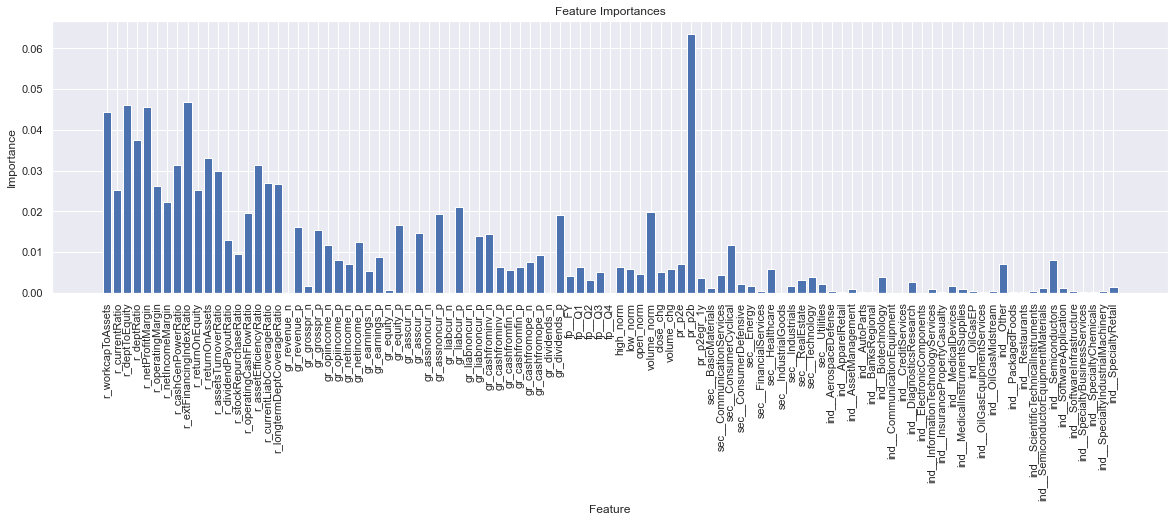

In [29]:
model = pipeline.stages[1]
importances = model.featureImportances
x_values = list(range(len(importances)))

f, ax = plt.subplots(figsize=(20,5))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, features, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

## 07_Create testdata and predict
The base testdataset contains all unseen data of all 2000+ companies.

In [30]:
testdata = df_joined.where(col('ticker').isin(top_500)) \
                 .where(filter_no_potential) \
                 .where(filter_date_from_2017)          
testdata.count()

424637

In [31]:
# for some reason there is a data point which has a null value somewhere.. so we make sure that there are no null values
testdata = testdata.na.drop(how="any")
testdata.count()

424626

In [32]:
df_predicted = pipeline.transform(testdata)

In [33]:
# create pandas dataframe
df_predicted_pd_orig = df_predicted.drop('features').toPandas()
df_predicted_pd = df_predicted_pd_orig.copy()

In [60]:
robo_train_cls = ['ticker', 'Date', 'r_potential','prediction', 'Close','High','Low', 'Open']
df_predicted_pd[robo_train_cls].sort_values(['ticker','Date']).to_csv(trainingset_folder + "robo_train_set.csv", header=True, index=False)

## 08_Analysis

### Tools

In [34]:
# to be able to filter directly on the year, let's add a year column
df_predicted_pd['close_year'] = pd.DatetimeIndex(df_predicted_pd['Date']).year

In [35]:
def calc_rsme(df:pd.DataFrame):
    rmse = ((df.r_potential-df.prediction)**2).mean()**0.5
    return rmse

In [36]:
def draw_scatter(df_arr:List[pd.DataFrame], labels: List[str]):
    number = len(df_arr)
    fig, ax = plt.subplots(1, number, figsize=(number * 7,5))

    if number > 1:
        for i in range(number):
            ax[i].plot(df_arr[i].r_potential, df_arr[i].prediction,'b.')

            ax[i].set_title(labels[i])
            
            ax[i].set_ylim(-1,5)
            ax[i].set_xlim(-1,10)
            

            ax[i].set(xlabel='Potential', ylabel='Prediction')
    else:
            ax.plot(df_arr[0].r_potential, df_arr[0].prediction,'b.')

            ax.set_title(labels[0])

            ax.set_ylim(-1,5)
            ax.set_xlim(-1,10)
            
            ax.set(xlabel='Potential', ylabel='Prediction')

In [37]:
def create_groups(df:pd.DataFrame) -> List[pd.DataFrame]:
    pred_all =     df
    pred_min_10 =  df[df.prediction >  0.1]
    pred_min_30 =  df[df.prediction >  0.3]
    pred_min_50 =  df[df.prediction >  0.5]
    pred_min_75 =  df[df.prediction >  0.75]
    pred_min_100 = df[df.prediction >  1.0]
    pred_min_150 = df[df.prediction >  1.5]

    data_sets = [pred_all, pred_min_10, pred_min_30, pred_min_50, pred_min_75, pred_min_100, pred_min_150]
    return data_sets

group_labels = ['all', 'above 10%', 'above 30%','above 50%','above 75%','above 100%','above 150%']

In [38]:
def draw_box(list_df:List[pd.DataFrame]):
    data = [x.r_potential.tolist() for x in list_df]

    fig, ax = plt.subplots(figsize=(20,7))
    ax.boxplot(data, showmeans=True)
    ax.set_ylim(-1,3)
    plt.xticks(np.arange(len(group_labels))+1, group_labels)
    plt.show()

### Overall

In [39]:
df_predicted_pd=df_predicted_pd[df_predicted_pd.r_potential<15]

In [40]:
print("Overall Model Performance RMSE: %f" % calc_rsme(df_predicted_pd))

Overall Model Performance RMSE: 0.401875


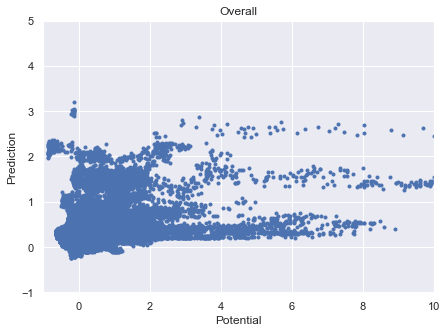

In [41]:
draw_scatter([df_predicted_pd],['Overall'])

### by Year Top 500

In [42]:
df_2017 = df_predicted_pd[(df_predicted_pd.close_year == 2017)]
df_2018 = df_predicted_pd[(df_predicted_pd.close_year == 2018)]
df_2019 = df_predicted_pd[(df_predicted_pd.close_year == 2019)]
df_2020 = df_predicted_pd[(df_predicted_pd.close_year == 2020)]

In [43]:
print("2017 Model Performance RMSE: %f" % calc_rsme(df_2017))
print("2018 Model Performance RMSE: %f" % calc_rsme(df_2018))
print("2019 Model Performance RMSE: %f" % calc_rsme(df_2019))
print("2020 Model Performance RMSE: %f" % calc_rsme(df_2020))

2017 Model Performance RMSE: 0.409375
2018 Model Performance RMSE: 0.316919
2019 Model Performance RMSE: 0.411977
2020 Model Performance RMSE: 0.524425


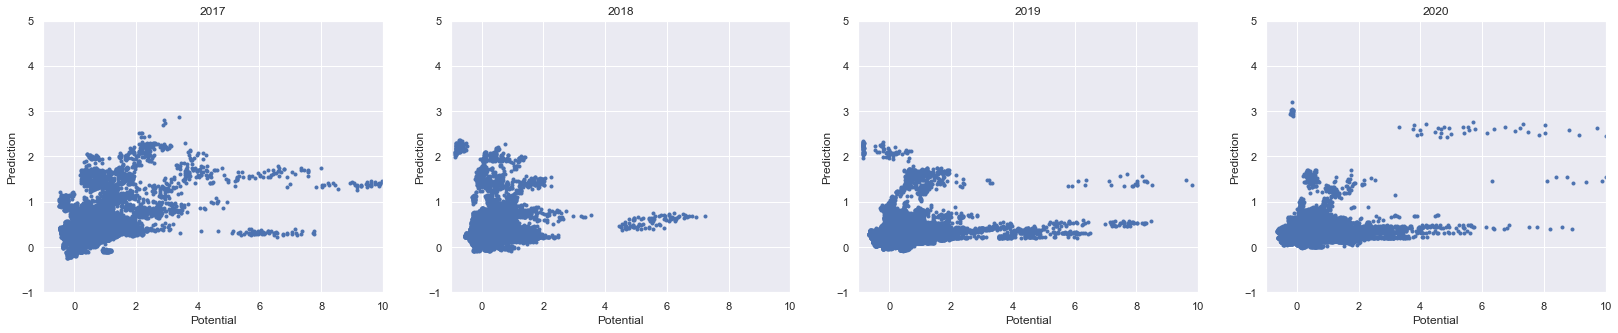

In [44]:
draw_scatter([df_2017, df_2018, df_2019,df_2020],['2017','2018','2019','2020'])

### Groups by year

In [52]:
groups_top500_all = create_groups(df_predicted_pd)
groups_top500_2017 = create_groups(df_2017)
groups_top500_2018 = create_groups(df_2018)
groups_top500_2019 = create_groups(df_2019)
groups_top500_2020 = create_groups(df_2020)

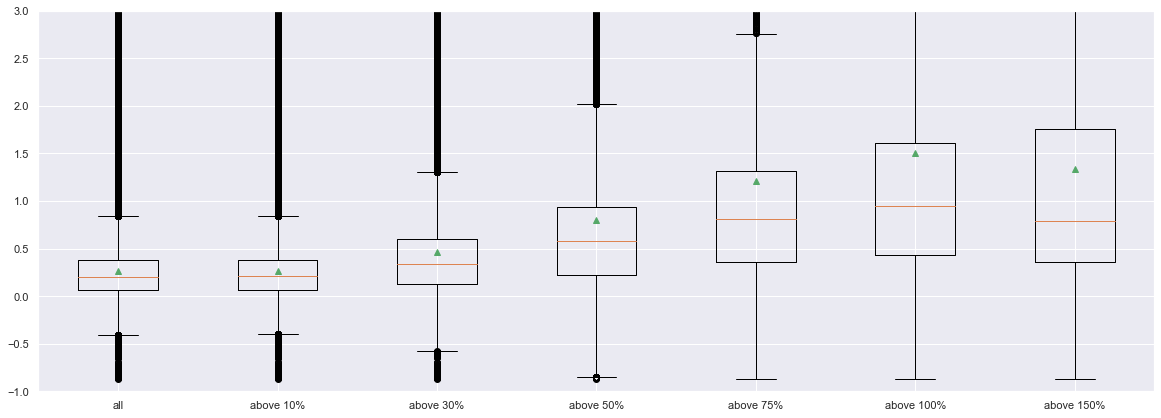

In [53]:
draw_box(groups_top500_all)

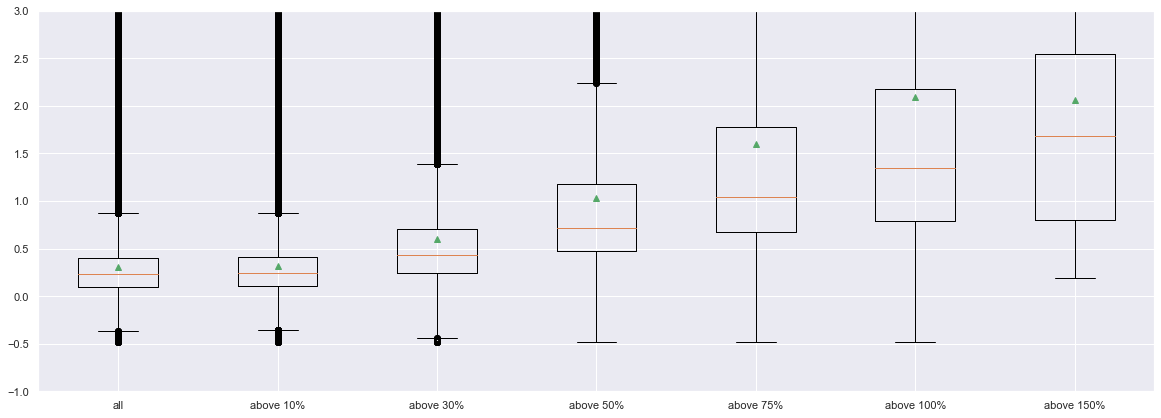

In [54]:
draw_box(groups_top500_2017)

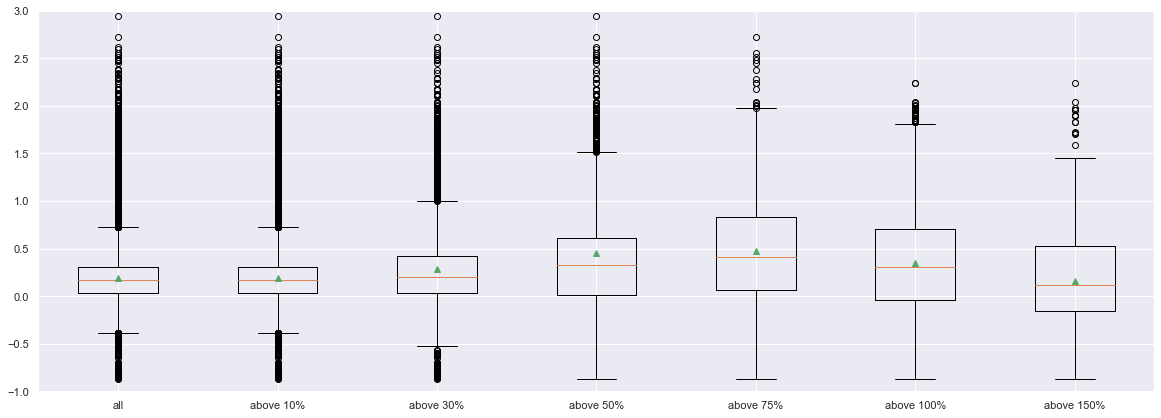

In [55]:
draw_box(groups_top500_2018)

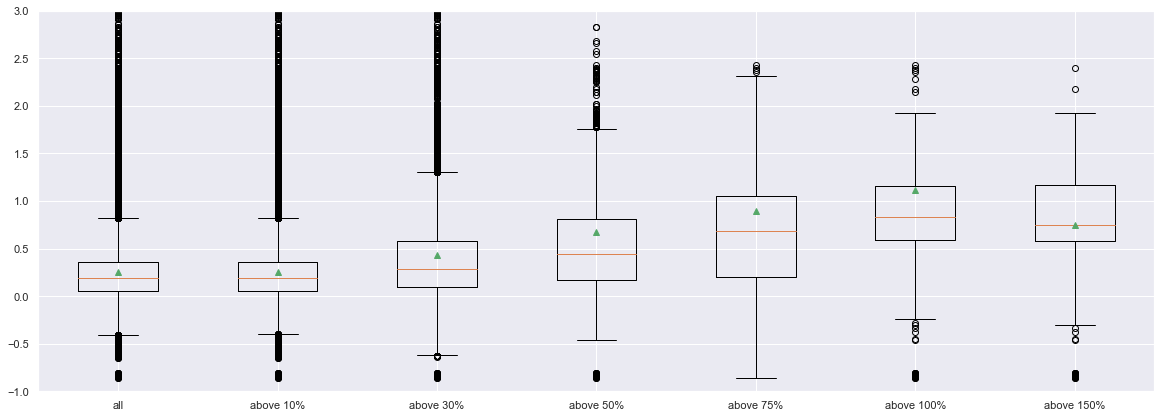

In [56]:
draw_box(groups_top500_2019)

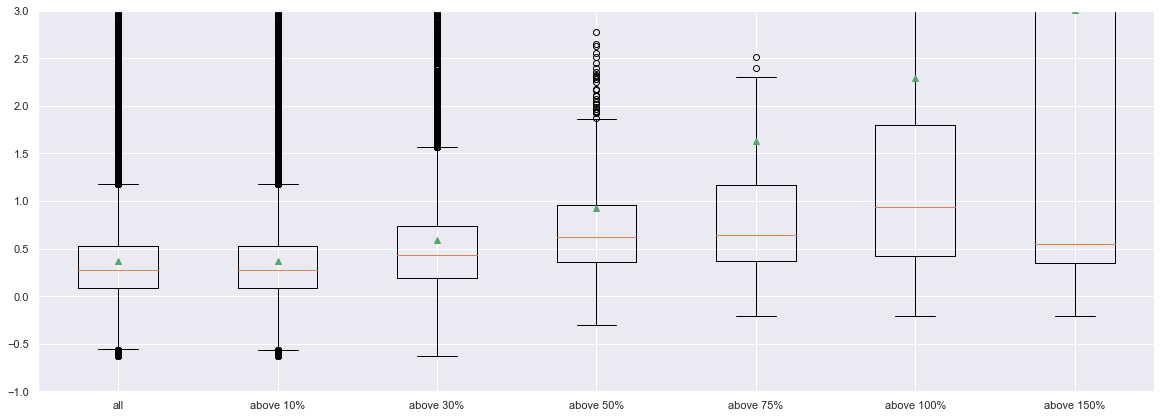

In [57]:
draw_box(groups_top500_2020)

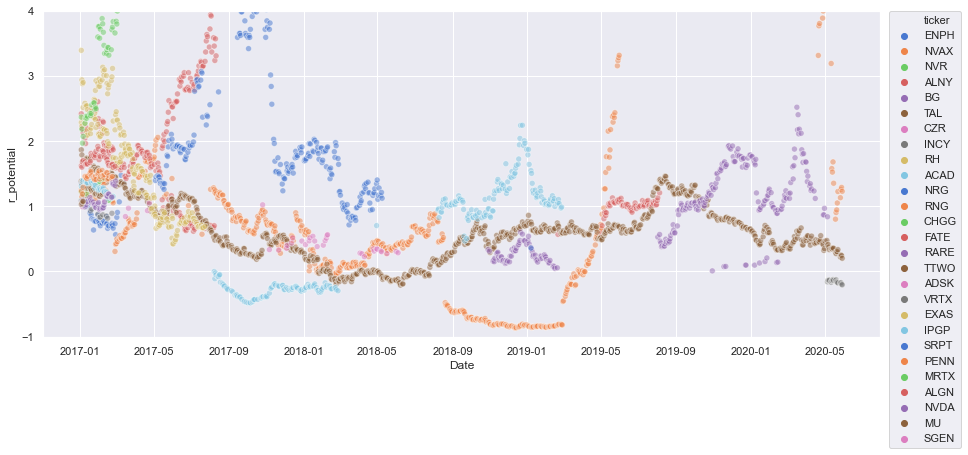

In [58]:
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(x="Date", y="r_potential", hue="ticker",  #size="prediction",
            sizes=(40, 400), alpha=.5, palette="muted",
            ax = ax, data= groups_top500_all[5])
ax.set_ylim(-1,4)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

## 99_stop spark

In [144]:
spark.stop()

## XX_Trials

ticker
ABMD    AxesSubplot(0.125,0.125;0.775x0.755)
ACAD    AxesSubplot(0.125,0.125;0.775x0.755)
ADSK    AxesSubplot(0.125,0.125;0.775x0.755)
ALNY    AxesSubplot(0.125,0.125;0.775x0.755)
AMD     AxesSubplot(0.125,0.125;0.775x0.755)
AMED    AxesSubplot(0.125,0.125;0.775x0.755)
CHGG    AxesSubplot(0.125,0.125;0.775x0.755)
DXCM    AxesSubplot(0.125,0.125;0.775x0.755)
ENPH    AxesSubplot(0.125,0.125;0.775x0.755)
FATE    AxesSubplot(0.125,0.125;0.775x0.755)
FSLR    AxesSubplot(0.125,0.125;0.775x0.755)
FTNT    AxesSubplot(0.125,0.125;0.775x0.755)
LULU    AxesSubplot(0.125,0.125;0.775x0.755)
MRTX    AxesSubplot(0.125,0.125;0.775x0.755)
NBIX    AxesSubplot(0.125,0.125;0.775x0.755)
NFLX    AxesSubplot(0.125,0.125;0.775x0.755)
NVAX    AxesSubplot(0.125,0.125;0.775x0.755)
RARE    AxesSubplot(0.125,0.125;0.775x0.755)
RNG     AxesSubplot(0.125,0.125;0.775x0.755)
SGEN    AxesSubplot(0.125,0.125;0.775x0.755)
SRPT    AxesSubplot(0.125,0.125;0.775x0.755)
TAL     AxesSubplot(0.125,0.125;0.775x0.755)
TWT

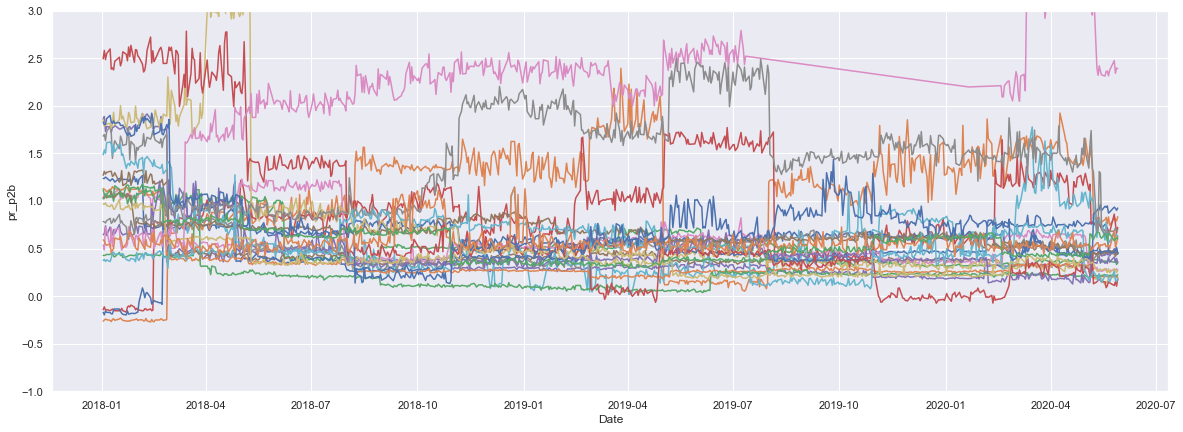

In [143]:
df_top500[df_top500.ticker.isin(selection_2018)].set_index('Date').groupby('ticker')['prediction'].plot(figsize=(20,7), ylabel="pr_p2b",ylim=(-1,3))

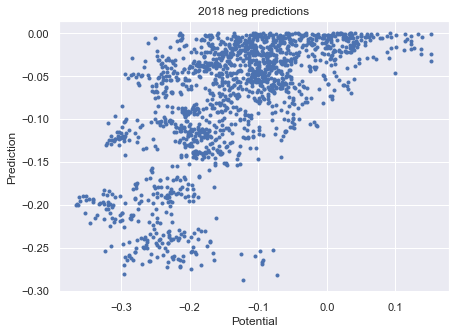

In [201]:
df_top500_2018_neg_pred = df_top500_2018[df_top500_2018.prediction < 0]
draw_box([df_top500_2018_neg_pred],['2018 neg predictions'])

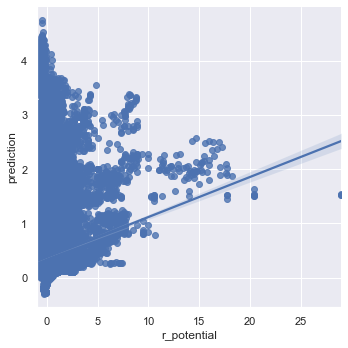

In [157]:
import seaborn as sns
sns.lmplot(x='r_potential',y='prediction',data=df_2018,fit_reg=True) 

In [107]:
df_predicted_pd.dtypes

ticker         object
cik             int32
adsh           object
period         object
filed          object
               ...   
mc_top200     float64
mc_top500     float64
mc_top1000    float64
prediction    float64
close_year      int64
Length: 161, dtype: object

In [137]:
df_osa = df_all.where('ticker == "ENPH"').toPandas()

In [138]:
df_osa['i_date'] = df_osa.Date
df_osa.set_index('i_date', inplace = True)

In [141]:
df_osa.close_norm.plot(figsize=(15,5))

KeyError: "['prediction'] not in index"

<AxesSubplot:xlabel='i_date'>

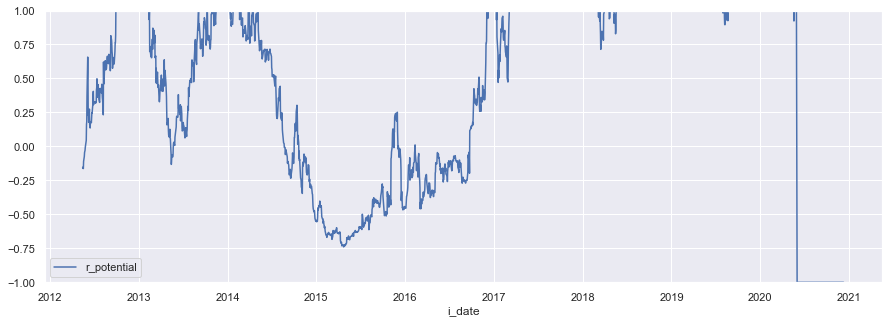

In [140]:
df_osa[['r_potential']].plot(figsize=(15,5),ylim=(-1,1))

<AxesSubplot:xlabel='i_date'>

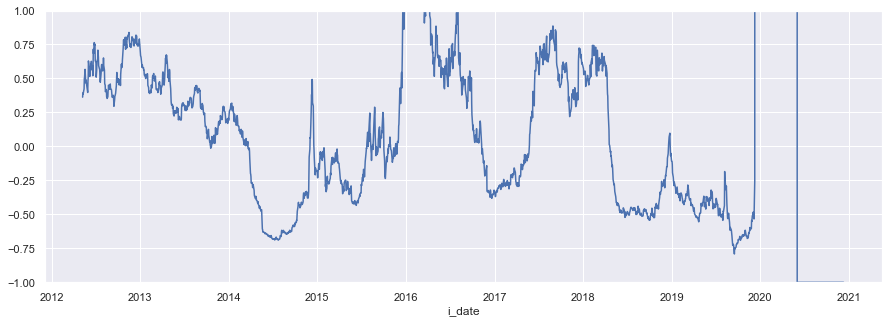

In [149]:
df_osa.r_potential_2.plot(figsize=(15,5),ylim=(-1,1))

<AxesSubplot:xlabel='i_date'>

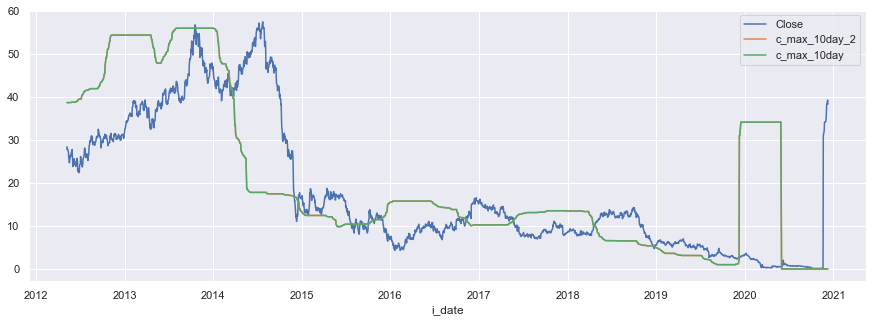

In [143]:
df_osa[['Close', 'c_max_10day_2', 'c_max_10day']].plot(figsize=(15,5))

<AxesSubplot:xlabel='i_date'>

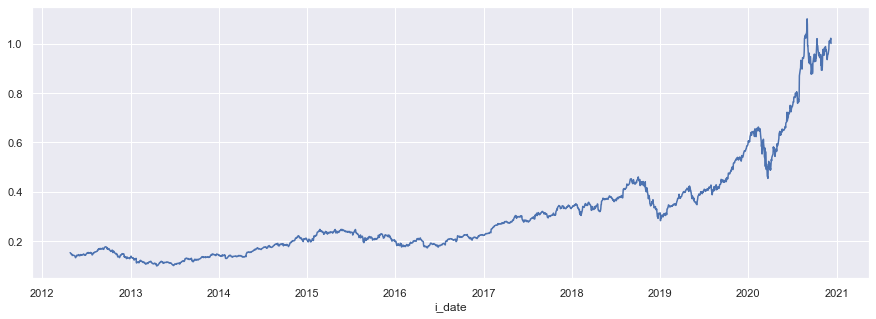

In [133]:
df_osa.close_norm.plot(figsize=(15,5))

In [141]:
def find_10_day_max(date, close, df):
    date_low = date + pd.DateOffset(days=180)
    date_high =  date + pd.DateOffset(days=360)

    # return df[(df.Date >= date_low) & ((df.Date <= date_high))].Close.max()
    close_list = df[(df.Date >= date_low) & (df.Date <= date_high)].Close.sort_values(ascending=False).to_list()
    if len(close_list) >= 10:
        return close_list[9]
    return 0


def calculate_potential(combined_data):
    combined_data['c_max_10day_2'] = combined_data.apply(lambda row : find_10_day_max(row['Date'], row['Close'], combined_data), axis = 1)
    combined_data['r_potential_2'] = ((combined_data.c_max_10day_2 - combined_data.Close) / combined_data.Close)

In [142]:
calculate_potential(df_osa)

In [124]:
df_osa['Date_p180'] = df_osa.Date +  pd.DateOffset(days=180)
df_osa['Date_p360'] = df_osa.Date +  pd.DateOffset(days=360)

In [147]:
df_osa[['Date','Close','c_max_10day_2']]

,Date,Close,c_max_10day_2
i_date,,,
2012-05-08,2012-05-08,28.379999,38.66
2012-05-09,2012-05-09,27.750000,38.66
2012-05-10,2012-05-10,27.910000,38.66
2012-05-11,2012-05-11,27.709999,38.66
2012-05-14,2012-05-14,27.170000,38.66
...,...,...,...
2020-12-03,2020-12-03,36.560001,0.00
2020-12-04,2020-12-04,38.169998,0.00
2020-12-07,2020-12-07,39.000000,0.00


In [90]:
calculate_potential(df_osa)

In [67]:
df_predicted_pd[df_predicted_pd.r_potential > 20]['ticker'].unique()

array(['NVAX', 'WLL', 'TUP', 'ECTE', 'KIRK', 'PEIX', 'IBIO', 'OAS'],
      dtype=object)

In [68]:
df_predicted_pd[df_predicted_pd.r_potential > 20]['Date'].unique()

array([datetime.date(2019, 7, 26), datetime.date(2019, 7, 29),
       datetime.date(2019, 7, 30), datetime.date(2019, 7, 31),
       datetime.date(2019, 8, 1), datetime.date(2019, 8, 2),
       datetime.date(2019, 8, 5), datetime.date(2019, 8, 6),
       datetime.date(2019, 8, 7), datetime.date(2019, 8, 8),
       datetime.date(2019, 8, 9), datetime.date(2019, 8, 12),
       datetime.date(2019, 8, 13), datetime.date(2019, 8, 14),
       datetime.date(2019, 8, 15), datetime.date(2019, 8, 20),
       datetime.date(2019, 8, 21), datetime.date(2019, 8, 22),
       datetime.date(2019, 8, 23), datetime.date(2019, 8, 26),
       datetime.date(2019, 8, 27), datetime.date(2019, 8, 28),
       datetime.date(2019, 8, 29), datetime.date(2019, 8, 30),
       datetime.date(2019, 9, 3), datetime.date(2019, 9, 4),
       datetime.date(2019, 9, 5), datetime.date(2019, 9, 6),
       datetime.date(2019, 9, 9), datetime.date(2019, 9, 10),
       datetime.date(2019, 9, 11), datetime.date(2019, 9, 12),
    